### 04 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측
LinearRegression : 규제가 적용되지 않은 선형 회귀를 구현한 클래스

#### 1) LinearRegression 클래스 - Ordinary Least Squares
- LinearRegression 클래스 : 예측값과 실제 값의 RSS(Residual Sum of Squares)를 최소화해 OLS(Ordinary Least Squares) 추정방식으로 구현
- fit() 메서드로 X, y 배열을 입력받아 회귀계수인 W를 coef_ 속성에 저장
class sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
- OLS 기반의 회귀계수 계산은 입력 피처의 독립성에 많은 영향을 받음
- 피처 간의 상관관계가 매우 높은 경우 분산이 매우 커져 오류에 매우 민감해짐 => **다중 공선성(multi-collinearity)** 문제
 - 상관관계가 높은 피처가 많은 경우 독립적인 중요한 피처만 남기고 제거하거나 규제를 적용함
 - 많은 피처가 다중 공선성 문제를 가지고 있다면 PCA를 통해 차원 축소를 수행하는 것을 고려

#### 2) 회귀 평가 지표
1. MAE : Mean Absolute Error, 실제값과 예측값의 차이를 절댓값으로 변환해 평균함
 1. API; metrics.mean_absolute_error
 2. scoring 함수 적용값; neg_mean_absolute_error
2. MSE : Mean Squared Error, 실제값과 예측값의 차이를 제곱해 평균함
 1. API; metrics.mean_squared_error
 2. scoring 함수 적용값; neg_mean_squared_error
3. RMSE : Root Mean Squared Error
 1. API; metrics.r2_score
 2. scoring 함수 적용값; r2
4. $R^2$ : 분산 기반으로 예측 성능 평가. 1에 가까울수록 예측 정확도가 높음
- 그외 MSLE(Mean Squared Log Error), RMSLE(Root Mean Squared Log Error)
- Scoring 함수에 회귀 평가 지표를 적용할 때, 'neg_' 접두어가 붙어있는 경우 음수 값을 가지기 때문에 (사이킷런의 Scoring 함수가 score 값이 클수록 좋은 평가 결과로 자동 평가하기 때문) 보정이 필요함
 - 사이킷런의 지표 평가 기준은 높은 지표 값일수록 좋은 모델인 데 반해, 일반적으로 회귀는 MSE 값이 낮을수록 좋은 회귀 모델

#### 3) LinearRegression을 이용해 보스턴 주택 가격 회귀 구현

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

# boston 데이터 세트 로드
boston = load_boston()

# boston 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

# boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICE 칼럼으로 DataFrame에 추가함
bostonDF['PRICE']=boston.target
print('Boston 데이터 세트 크기:', bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


- 데이터 세트 피처의 Null값은 없으며 두 float 형 (bostonDF.info()로 확인)

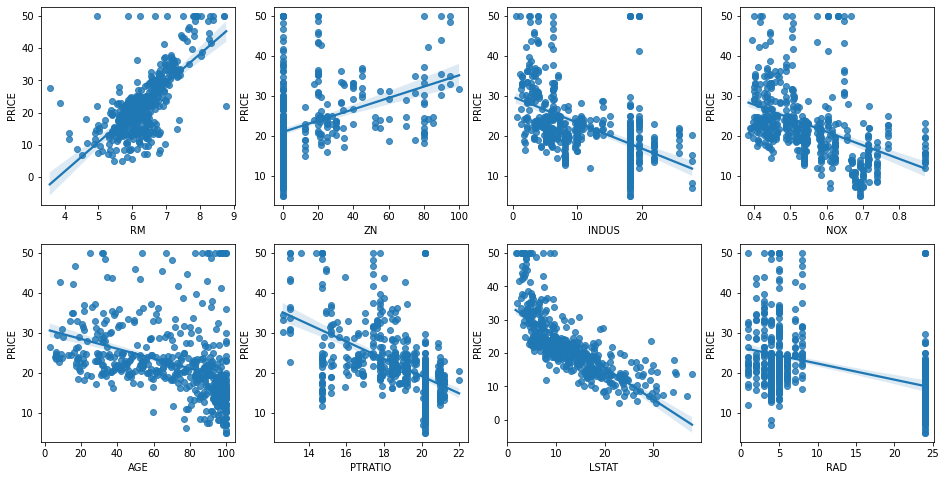

In [2]:
# 2개의 행과 4개의 열을 가진 subplots 이용. axs는 4*2개의 ax를 가짐
#  subplot()에서 ncols는 열방향으로 위치할 그래프의 개수, nrows는 행 방향으로 위치할 그래프의 개수
fig,axs = plt.subplots(figsize=(16,8), ncols=4,nrows=2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i, feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    #   regplot() API는 X, Y축 값의 산점도와 함께 선형 회귀 직선을 그려줌
    # 각 ax마다 칼럼과 PRICE의 관계 표현 
    # 각 칼럼이 회귀 결과에 미치는 영향이 어느 정도인지 시각화
    sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

- RM과 LSTAT의 PRICE 영향도가 가장 두드러지게 나타남
 - RM은 양 방향의 선형성이 가장크고, LSTAT는 음 방향의 선형성이 가장 큼
 - LSTAT이 적을수록 PRICE가 증가하는 모습이 확연히 나타남

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop('PRICE', axis=1, inplace = False)

# 학습과 테스트 데이터 세트를 분리해 학습과 예측 수행
X_train,X_test,y_train,y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)
 
# 선형 회귀 OLS로 학습/예측/평가 수행
lr = LinearRegression()
lr.fit(X_train,y_train)
y_preds = lr.predict(X_test)

# MSE와 R2 Score 측정
mse = mean_squared_error(y_test,y_preds)
rmse = np.sqrt(mse)

print('MSE: {0:.3f}, RMSE: {1:.3f}'.format(mse,rmse))
print('Variance score: {0:.3f}'.format(r2_score(y_test,y_preds)))

# LinearRegression으로 생성한 주택가격모델의 절편과 회귀 계수 값
print('intercept: ', lr.intercept_)
print('slope: ', np.round(lr.coef_,1))

MSE: 17.297, RMSE: 4.159
Variance score: 0.757
intercept:  40.995595172164336
slope:  [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [4]:
# coef_ 속성은 회귀 계수 값만 가지고 있으므로 이를 피처별 회귀 계수 값으로 다시 매핑
# 회귀 계수를 sort_values() 함수를 이용해 큰 값 순으로 정렬하기 위해 Series로 생성. 인덱스 칼럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_,1), index=X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

- RM이 양의 값으로 회귀 계수가 가장 큼
- NOX 피처의 회귀 계수 -값이 너무 커 보임 => 최적화를 수행하며 피처 coefficients 변화도 같이 살펴봐야함

In [5]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)
lr = LinearRegression()

# cross_val_score()로 5 폴드 세트로 MSE를 구한 뒤 이를 기반으로 다시 RMSE 구함
neg_mse_scores = cross_val_score(lr, X_data, y_target,  scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수
print('5개 폴드의 개별 Negative MSE scores: ', np.round(neg_mse_scores,2))
print('5개 폴드의 개별 RMSE scores: ', np.round(rmse_scores,2))
print('5개 폴드의 평균 RMSE: {0:.3f}'.format(avg_rmse))

5개 폴드의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
5개 폴드의 개별 RMSE scores:  [3.53 5.1  5.75 8.99 5.77]
5개 폴드의 평균 RMSE: 5.829
